In [23]:
import os
import cv2
import random
import tensorflow
import numpy as np
from matplotlib import pyplot as plt
import time
import random

In [24]:
root = "./"
test_dir = os.path.join(root, "exmpl/")
test_dir_original = os.path.join(root, "exmpl_orig/")

all_img_names = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]

print(len(all_img_names))

110


In [69]:
def get_banch_images(test_dir, roots, dem_size):
    x = np.zeros((len(roots),) + (dem_size, dem_size) + (3,), dtype="float32")

    for ii in range(len(roots)):
        root_name = test_dir + roots[ii]
        img = cv2.imread(root_name)
        x[ii] = img / 255.0

    return x

dem_size = 128
banch_size = 100
banch_test_images = get_banch_images(test_dir, all_img_names[:banch_size], dem_size)

In [16]:
# print(banch_test_images[0])
# pic = cv2.cvtColor(banch_test_images[50], cv2.COLOR_BGR2RGB)
# plt.imshow(pic)

In [5]:
def get_denoising_bilat(test_images, dem_size):
    x = np.zeros((len(test_images),) + (dem_size, dem_size) + (3,), dtype="float32")

    for ii in range(len(test_images)):
        bilat = cv2.bilateralFilter(test_images[ii], d=3, sigmaColor=25, sigmaSpace=25)

        x[ii] = bilat

    return x

In [6]:
start = time.time()
denoise_bilat = get_denoising_bilat(banch_test_images, dem_size)
end = time.time()
print(end - start)

0.09041094779968262


In [8]:
# pic = cv2.cvtColor(denoise_bilat[50], cv2.COLOR_BGR2RGB)
# plt.imshow(pic)

In [12]:
def get_denoising_gaus(test_images, dem_size):
    x = np.zeros((len(test_images),) + (dem_size, dem_size) + (3,), dtype="float32")

    for ii in range(len(test_images)):
        gaus = cv2.GaussianBlur(test_images[ii], ksize=(3,3), sigmaX=5)

        x[ii] = gaus

    return x

In [13]:
start = time.time()
denoise_gaus = get_denoising_gaus(banch_test_images, dem_size)
end = time.time()
print(end - start)

0.02584385871887207


In [17]:
# pic = cv2.cvtColor(denoise_gaus[50], cv2.COLOR_BGR2RGB)
# plt.imshow(pic)

In [18]:
u_model = tensorflow.keras.models.load_model('denoize3channel.keras')

In [19]:
def get_denoising_u_model(test_images, u_model):
    pred = u_model.predict(test_images)
    return pred

In [20]:
start = time.time()
denoise_u = get_denoising_u_model(banch_test_images, u_model)
end = time.time()
print(end - start)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 848ms/step
4.499803066253662


In [22]:
# cliped = np.clip(denoise_u[8], 0, 1)
# pic = cv2.cvtColor(cliped, cv2.COLOR_BGR2RGB)
# plt.imshow(pic)

In [62]:
def show_random_example(original_path, noised, gaus, bilateral, u_model, max_samples):
    ii = random.randint(0, max_samples)

    # name = original_path+"image"+str(ii)+".jpg"
    # print(name)
    # orig_img = cv2.imread(name)
    # orig_img = cv2.resize(orig_img, (dem_size, dem_size));

    pic_nois = cv2.cvtColor(noised[ii], cv2.COLOR_BGR2RGB)
    pic_gaus = cv2.cvtColor(gaus[ii], cv2.COLOR_BGR2RGB)
    pic_bil = cv2.cvtColor(bilateral[ii], cv2.COLOR_BGR2RGB)
    pic_u_model = cv2.cvtColor(np.clip(denoise_u[ii], 0, 1), cv2.COLOR_BGR2RGB)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    ax1.imshow(pic_nois)
    ax2.imshow(pic_gaus)
    ax3.imshow(pic_bil)
    ax4.imshow(pic_u_model)

./exmpl_orig/image8.jpg


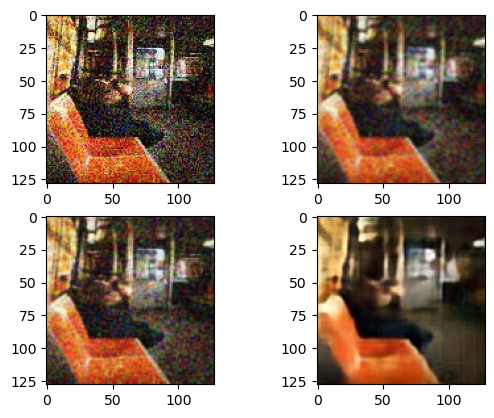

In [68]:
show_random_example(test_dir_original, banch_test_images, denoise_gaus, denoise_bilat, denoise_u, banch_size)

Denoising

Dataset source
https://www.kaggle.com/datasets?search=object+detection

comparison:
BilateralFilter, GaussianBlur

Description:
Для вирішення спробував використати U модель.

В тестових варіантах  випробувано:
- greyscale варінт для зменшення кількості параметрів в мережі, але використання більших зображень 300*300
- для останнього шaру конволюції - використання Relu активації - після кількох епох результат був поганий
- також софт-мкс із 255 класами - але ноутбук не потягнув оброблення такого масиву інформації

Вирішив використання 3 канальних зображень. І зменшити розмір зображень до 128 * 128.

Тренувальні дані 10 000+ картинок предметів, пейзажів, тварин і людей.
До картинок застосовано шум на основі розподілу гауса. Та в 2% випадках ефект скречінгу - видалення випадкових смуг пікселів, або закрашення їх в чорний.

Мережа пройшла треновання орієнтовно 45-50 епох

Візуальний ефект на мою думку не задовільний. Хоча в певних випадках кращий за Білатеральний Гаусовий фільтри.
Visually: 4/10

Варіант рішення змінити архітеркуру шарів. І добавити ще 1 цикл енкодингу декодингу. Оскільки зараз найменший філтр розміром 8*8 пікселів. Можливо можна спробувати із 4*4 пікселі.

Алгоритм поступається Білатеральному та Гаусовому в швидкодії.

data processing time :

bilateralFilter - 0.1 sec / 100 pic

GaussianBlur - 0.03 sec / 100 pic

u_filter - 4.4 sec / 100 pic

Висновки.
Алгоритм ще має потенціал навчання і покращити ефективність на пару відсотків.
Плани: завершити тренунування алгоритму додатковими 10-15 епохами.
Якщо ефект буде не задовільний спробувати варіант з глибшим процесом енкодингу декодингу для фільтрів меншого розміру.
Спробувати ще раз  greyscale алгоритм, але з більшим резолюшеном картинок.
Спробувати greyscale - квантування до 4 кольорів - кластеризацію - dithering
Допрацювати інтерфейс і автоматизацію можливості загружати картинки довільного резолюшену.
